In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [2]:
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

/root/anaconda3/envs/cp_amazy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics

In [4]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

In [5]:
!pip freeze > requirements.txt

# SETUP

In [6]:
CONFIG_DIR = '../app/'

In [7]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [8]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-21'

In [9]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [10]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1664128734,40253,23764,sell,0x001f581ca7fb3a01bd2c7ef4577e1bf22e15e7c0,NaN,0.79,sneakers,common,sprinter,...,565.0,8544.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.288660
1,1664128701,40252,23732,sell,0x001f581ca7fb3a01bd2c7ef4577e1bf22e15e7c0,NaN,0.79,sneakers,common,sprinter,...,565.0,8544.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.293103
2,1664128644,40251,27717,sell,0x80c9ff9bc539238e15dbd76013aa07708a3ac30c,NaN,0.72,sneakers,common,sprinter,...,564.0,8544.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.297578
3,1664128617,39950,27717,cancel,0x80c9ff9bc539238e15dbd76013aa07708a3ac30c,NaN,NaN,sneakers,common,sprinter,...,565.0,8544.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.293103
4,1664128605,40250,40428,sell,0x079220557729cceef4ec3e33110c9b402bb9db32,NaN,1.31,sneakers,common,hiker,...,564.0,8544.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.289655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52535,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
52536,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
52537,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,904,0,252,1495,1831,2314,NaN,NaN
52538,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,15934,3984,256,4545,5225,15934,NaN,NaN


In [11]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [12]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52540 entries, 0 to 52539
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  37166 non-null  float64
 1   time_ownership             37166 non-null  float64
 2   wallet_box_mint            37166 non-null  float64
 3   wallet_sneaker_mint        37166 non-null  float64
 4   time_level_up              34082 non-null  float64
 5   time_level_up_for_mint     37166 non-null  float64
 6   base_mint_price_amt        37166 non-null  float64
 7   base_mint_price_azy        37166 non-null  float64
 8   base_mint_price_bnb        27143 non-null  float64
dtypes: float64(9)
memory usage: 3.6 MB


In [13]:
data.genesis

0         True
1         True
2         True
3         True
4        False
         ...  
52535     True
52536    False
52537    False
52538    False
52539     True
Name: genesis, Length: 52540, dtype: bool

In [14]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
7,1664128560,39960,22896,buy,0x80917adc261c0eab8839f0b861fe698a8a88f9c9,0x10db1a53d39adcb8505c6f90b6ed25c7ef5566d1,0.74,sneakers,common,ranger,...,565.0,8544.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.278351
19,1664128296,40213,45491,buy,0x2e15b5515eddbacb4ff389b9128139c11773a542,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.69,sneakers,common,ranger,...,567.0,8542.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.293103
23,1664128230,40066,31039,buy,0xb6249d0e0c5678c5029728a98b50f31c176e7b48,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.68,sneakers,common,ranger,...,569.0,8542.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.291096
33,1664128110,40224,31290,buy,0xfe7e2202fdc75bc2562d0f00ab0f27b13f09fb71,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.66,sneakers,common,ranger,...,573.0,8542.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.311644
42,1664128014,39963,53277,buy,0xc5d01c99b5ff377fd5a9c66ce5d288942afd84ec,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.67,sneakers,common,ranger,...,578.0,8540.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,100.0,1.300676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52477,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
52500,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
52514,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
52519,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


# data_quality

In [15]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][0]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

In [16]:
data['mint'].isna().sum()

0

In [17]:
data[data['level'] == 9]['mint'].value_counts()

2.0    114
0.0     58
3.0     36
1.0     19
Name: mint, dtype: int64

In [18]:
data[data['level'] > 10]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
360,1664120676,40022,27367,buy,0xb794ed9c41014eaa74be9a8ede0b8f287c5999a3,0xb461fabc81689d05df757fbf91ae3825ed6f71f4,1.99,sneakers,common,coacher,...,612.0,8528.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,100.0,1.333333
513,1664117432,39911,37842,buy,0x45c8204825ea0ccfc50e256659e6cd93483eba5e,0x17a5d62acfd984b1629faeeb01df0124cee18037,2.70,sneakers,uncommon,hiker,...,611.0,8529.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,101.0,1.331148
678,1664113903,39854,49709,buy,0x57e92dbbff9fd26e16eb554935863c03665fc720,0x1ea671571e0e1cf11d0a2b3206642d09ccf396bb,3.49,sneakers,uncommon,ranger,...,606.0,8527.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,101.0,1.330000
988,1664107919,39616,49119,buy,0x402d3d216af90a41c2b00a989827a734cf9484b7,0x2d44b26165fb1ec036258919133001a5e71c568d,0.80,sneakers,common,ranger,...,574.0,8526.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.221843
1012,1664107616,39722,35013,buy,0x7bf059b6fd6d2d58d0fb3d27b33fc606f623fd27,0xbd1ff5e92de49932750fe4709ae5d788cc16b0ef,0.90,sneakers,common,ranger,...,568.0,8530.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.199313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47912,1661371295,16118,15092,buy,0x418a1e05650e9a053754c5688efeccc66690731e,0x05e5052fd465d5f5de2d7c0b230967ecb28518b8,0.90,sneakers,common,ranger,...,NaN,NaN,17470,4485,311,2399,6350,17470,NaN,NaN
48688,1661322877,15730,14692,buy,0xf6389b738e12464d401b576290dc1406bf5d3b0a,0x56bc8d10982e09d99cfb67fa3cbca2bfb0dc4525,1.50,sneakers,common,ranger,...,NaN,NaN,17224,4417,284,2324,6191,17224,NaN,NaN
49841,1661232037,15161,23928,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,7.66,sneakers,uncommon,coacher,...,NaN,NaN,16921,3733,531,5201,6000,16921,NaN,NaN
50202,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,NaN,NaN,16746,3720,452,5118,5868,16746,NaN,NaN


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9718 entries, 7 to 52533
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        9718 non-null   int64  
 1   mrk_id                                           9718 non-null   int64  
 2   token_id                                         9718 non-null   int64  
 3   event                                            9718 non-null   object 
 4   wallet_from                                      9718 non-null   object 
 5   wallet_to                                        9718 non-null   object 
 6   price                                            9718 non-null   float64
 7   item_type                                        9718 non-null   object 
 8   rarity                                           9718 non-null   object 
 9   sneaker_type                 

In [20]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9718 entries, 7 to 52533
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  9718 non-null   float64
 1   time_ownership             9718 non-null   float64
 2   wallet_box_mint            9718 non-null   float64
 3   wallet_sneaker_mint        9718 non-null   float64
 4   time_level_up              9718 non-null   float64
 5   time_level_up_for_mint     9718 non-null   float64
 6   base_mint_price_amt        9718 non-null   float64
 7   base_mint_price_azy        9718 non-null   float64
 8   base_mint_price_bnb        7328 non-null   float64
dtypes: float64(9)
memory usage: 759.2 KB


In [21]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
7,1.657836e+09,13798.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.595790
19,1.662571e+09,1563.0,2.0,2.0,900.0,1800.0,300.0,200.0,0.595790
23,1.659388e+09,3375111.0,12.0,19.0,900.0,1800.0,300.0,200.0,0.596687
33,1.657868e+09,3319316.0,3.0,3.0,900.0,1800.0,300.0,200.0,0.596687
42,1.657806e+09,470466.0,16.0,15.0,900.0,1800.0,300.0,200.0,0.596687
...,...,...,...,...,...,...,...,...,...
52477,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
52500,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
52514,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
52519,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [22]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [23]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [24]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [25]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9718 entries, 7 to 52533
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        9718 non-null   int64  
 1   mrk_id                                           9718 non-null   int64  
 2   token_id                                         9718 non-null   int64  
 3   event                                            9718 non-null   object 
 4   wallet_from                                      9718 non-null   object 
 5   wallet_to                                        9718 non-null   object 
 6   price                                            9718 non-null   float64
 7   item_type                                        9718 non-null   object 
 8   rarity                                           9718 non-null   object 
 9   sneaker_type                 

In [27]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
7,1664128560,39960,22896,buy,0x80917adc261c0eab8839f0b861fe698a8a88f9c9,0x10db1a53d39adcb8505c6f90b6ed25c7ef5566d1,0.74,sneakers,common,ranger,...,565.0,8544.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.278351
19,1664128296,40213,45491,buy,0x2e15b5515eddbacb4ff389b9128139c11773a542,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.69,sneakers,common,ranger,...,567.0,8542.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.293103
23,1664128230,40066,31039,buy,0xb6249d0e0c5678c5029728a98b50f31c176e7b48,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.68,sneakers,common,ranger,...,569.0,8542.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.291096
33,1664128110,40224,31290,buy,0xfe7e2202fdc75bc2562d0f00ab0f27b13f09fb71,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.66,sneakers,common,ranger,...,573.0,8542.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,99.0,1.311644
42,1664128014,39963,53277,buy,0xc5d01c99b5ff377fd5a9c66ce5d288942afd84ec,0xe40dacec2b3188ef42a48dbd64420e47c902dffc,0.67,sneakers,common,ranger,...,578.0,8540.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,100.0,1.300676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52477,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
52500,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
52514,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
52519,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


In [28]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

 фильтруем то что мы уже купили

In [29]:
len(data)

9718

In [30]:
data = data[data['wallet_to'] != '0x3273af210822c44afd7254510e612e4dbb1040a7']
len(data)

9509

уберем выбросы

In [31]:
data = data[(data['price'] > 0.4)]
len(data)

9505

In [32]:
data = data[~((data['genesis']) & (data['price'] < 0.6))].copy()
len(data)

9502

In [33]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [34]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [35]:
# data['bin_level'] = data['level'].replace({
# 0: 0,
# 1: 1, 2: 1, 3: 1, 4: 1, 
# 5: 2, 
# 6: 3, 7: 3, 8: 3,
# 9: 4, 
# 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5,
# 16: 6, 17: 6, 18: 6, 19: 6,
# 20: 7, 21: 7, 22: 7, 23: 7, 24: 7, 25: 7, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7,
# }).copy()

# data['bin_mint'] = data['mint'].replace({
# 0: 0,
# 1: 1, 
# 2: 2, 
# 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 
# }).copy()

In [36]:
#data['bin_level'].value_counts()

In [37]:
#data['bin_mint'].value_counts()

In [38]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_24H'] = calc_min_price_rolling(data, delta_h=24, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_48H'] = calc_min_price_rolling(data, delta_h=48, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_72H'] = calc_min_price_rolling(data, delta_h=72, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [39]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_6H'] = calc_min_price_rolling(data, delta_h=6, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [40]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [41]:
data['token_sell_activity_6H'].max()

11

In [42]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [43]:
#data['bin_level'] = data['bin_level'].astype(str)
#data['bin_mint'] = data['bin_mint'].astype(str)

# Model

In [44]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

5422

In [45]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [46]:
train_data[['price_bnb', 'price_azy', 'price_amt','base_mint_price_bnb']]

,price_bnb,price_azy,price_amt,base_mint_price_bnb
36552,277.756081,0.113478,0.552838,0.678822
36551,277.756081,0.113478,0.552838,0.678822
36545,278.034632,0.112454,0.552219,0.676738
36543,278.034632,0.112460,0.552195,0.676716
36531,278.702819,0.112101,0.552725,0.675406
...,...,...,...,...
11464,267.886007,0.073020,0.546289,0.666294
8415,271.074494,0.066887,0.540438,0.647456
11457,267.886007,0.073020,0.546289,0.666294
11450,267.374868,0.073338,0.548498,0.670284


In [47]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [48]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
36552,277.756081,0.113478,0.552838,1.661425e+09,23367.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:06:43
36551,277.756081,0.113478,0.552838,1.661425e+09,19236.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:07:58
36545,278.034632,0.112454,0.552219,1.659676e+09,1420813.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.676738,2022-09-03 00:22:19
36543,278.034632,0.112460,0.552195,1.661527e+09,529778.0,1.0,1.0,900.0,1800.0,300.0,200.0,0.676716,2022-09-03 00:23:43
36531,278.702819,0.112101,0.552725,1.657802e+09,2278671.0,1.0,1.0,3300.0,1800.0,300.0,200.0,0.675406,2022-09-03 00:55:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11464,267.886007,0.073020,0.546289,1.657820e+09,24.0,6.0,6.0,900.0,1800.0,300.0,200.0,0.666294,2022-09-20 23:02:46
8415,271.074494,0.066887,0.540438,1.657811e+09,4138417.0,5.0,4.0,900.0,1800.0,300.0,200.0,0.647456,2022-09-20 23:06:25
11457,267.886007,0.073020,0.546289,1.657810e+09,393.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.666294,2022-09-20 23:07:13
11450,267.374868,0.073338,0.548498,1.660643e+09,20660.0,0.0,0.0,12600.0,1800.0,300.0,200.0,0.670284,2022-09-20 23:13:25


In [49]:
train_data.base_mint_price_azy.value_counts()

200.0     5064
800.0      355
3200.0       3
Name: base_mint_price_azy, dtype: int64

In [50]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'bin_level',
    #'bin_mint',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    #'buy_count_12H',
    'buy_count_24H',
    'min_price_all_24H',
    #'sum_activity_24H',
    'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_6H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_48H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_72H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    #'wallet_first_sneaker_time',
    #'time_ownership', 
    #'wallet_box_mint', 
    #'wallet_sneaker_mint',
    'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    ]
cat_features = [0, 1, 2,]
# cat_features = [
#     'rarity',
#     'sneaker_type',
#     'genesis',
#     'bin_level',
#     'bin_mint',
#     ]


In [51]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [52]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        #depth=5,
        #loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:01,  1.91s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:03,  1.90s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:05,  1.91s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:07,  1.92s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:09,  1.90s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:11,  1.89s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:13,  1.88s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:15,  1.88s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:17,  1.88s/it]iteritems is deprec

In [53]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.912,0.0712
MAE,0.090,0.0170
MSE,0.128,0.1451
RMSE,0.321,0.1616
MAPE,0.057,0.0032


In [54]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.912,0.0712
MAE,0.090,0.0170
MSE,0.128,0.1451
RMSE,0.321,0.1616
MAPE,0.057,0.0032


In [55]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.899, 'MAE': 0.09, 'MSE': 0.128, 'RMSE': 0.358, 'MAPE': 0.057}

In [56]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


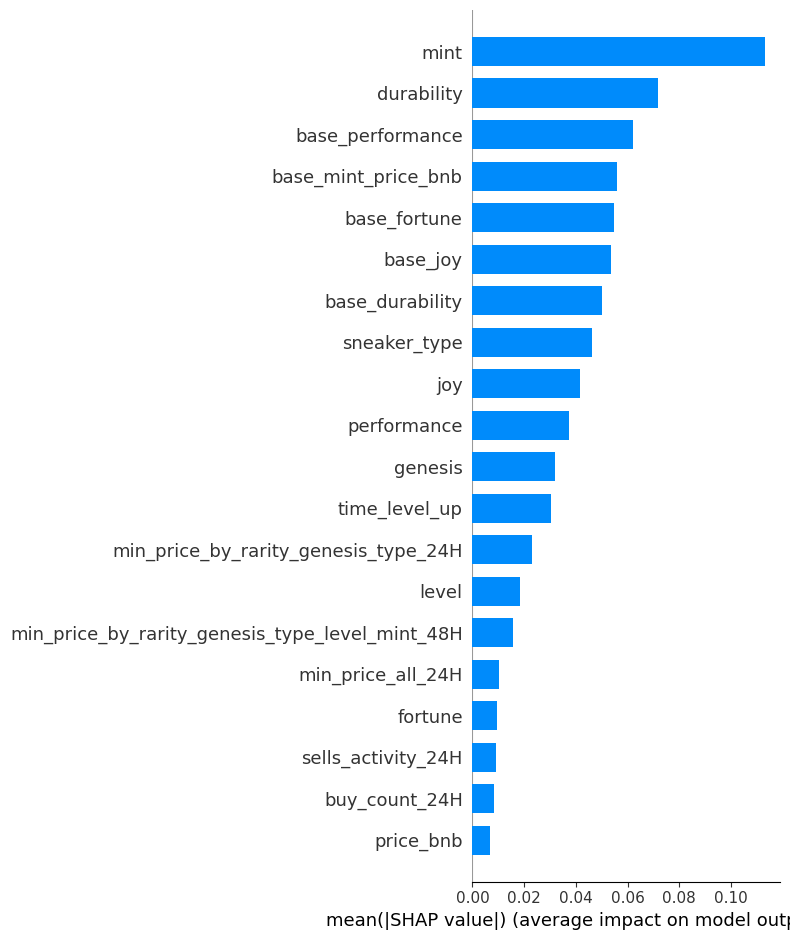

In [57]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [58]:
model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

Learning rate set to 0.053478
0:	learn: 1.0859078	total: 2.97ms	remaining: 2.96s
1:	learn: 1.0430508	total: 5.67ms	remaining: 2.83s
2:	learn: 1.0051436	total: 8.22ms	remaining: 2.73s
3:	learn: 0.9657920	total: 10.8ms	remaining: 2.7s
4:	learn: 0.9308321	total: 13.3ms	remaining: 2.65s
5:	learn: 0.8958240	total: 15.8ms	remaining: 2.61s
6:	learn: 0.8638397	total: 18.2ms	remaining: 2.59s
7:	learn: 0.8316410	total: 20.7ms	remaining: 2.57s
8:	learn: 0.8033240	total: 23ms	remaining: 2.53s
9:	learn: 0.7761084	total: 25.2ms	remaining: 2.5s
10:	learn: 0.7504352	total: 27.5ms	remaining: 2.47s
11:	learn: 0.7279378	total: 29.7ms	remaining: 2.44s
12:	learn: 0.7058292	total: 31.7ms	remaining: 2.41s
13:	learn: 0.6840231	total: 33.6ms	remaining: 2.37s
14:	learn: 0.6633964	total: 35.7ms	remaining: 2.34s
15:	learn: 0.6433895	total: 38.3ms	remaining: 2.35s
16:	learn: 0.6229303	total: 40.5ms	remaining: 2.34s
17:	learn: 0.6051068	total: 42.8ms	remaining: 2.33s
18:	learn: 0.5889685	total: 44.9ms	remaining: 2.

In [59]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.855, 'MAE': 0.106, 'MSE': 0.105, 'RMSE': 0.324, 'MAPE': 0.085}

In [60]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.855, 'MAE': 0.106, 'MSE': 0.105, 'RMSE': 0.324, 'MAPE': 0.085}

In [61]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.855, 'MAE': 0.106, 'MSE': 0.105, 'RMSE': 0.324, 'MAPE': 0.085}

## Fit full Model

In [62]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.055464
0:	learn: 1.0355737	total: 2.79ms	remaining: 2.79s
1:	learn: 0.9944301	total: 5.7ms	remaining: 2.84s
2:	learn: 0.9563279	total: 8.53ms	remaining: 2.83s
3:	learn: 0.9197773	total: 10.9ms	remaining: 2.72s
4:	learn: 0.8839928	total: 13.3ms	remaining: 2.64s
5:	learn: 0.8492862	total: 15.4ms	remaining: 2.55s
6:	learn: 0.8171461	total: 17.4ms	remaining: 2.46s
7:	learn: 0.7887423	total: 19.4ms	remaining: 2.41s
8:	learn: 0.7606826	total: 21.5ms	remaining: 2.36s
9:	learn: 0.7348748	total: 23.5ms	remaining: 2.32s
10:	learn: 0.7088119	total: 25.6ms	remaining: 2.3s
11:	learn: 0.6838635	total: 27.6ms	remaining: 2.27s
12:	learn: 0.6610194	total: 29.6ms	remaining: 2.24s
13:	learn: 0.6403314	total: 31.7ms	remaining: 2.23s
14:	learn: 0.6206707	total: 33.7ms	remaining: 2.21s
15:	learn: 0.6015819	total: 36.1ms	remaining: 2.22s
16:	learn: 0.5823132	total: 39.7ms	remaining: 2.3s
17:	learn: 0.5642255	total: 42.1ms	remaining: 2.29s
18:	learn: 0.5476033	total: 44.1ms	remaining: 2

### Test

In [63]:
i=1800

In [64]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sample = pd.Series(sneaker_dict)
sample[model.feature_names_]

rarity                                                 common
sneaker_type                                         sprinter
genesis                                                 False
level                                                     0.0
base_performance                                          8.9
base_fortune                                              8.0
base_joy                                                  7.4
base_durability                                           3.8
performance                                               8.9
fortune                                                   8.0
joy                                                       7.4
durability                                                3.8
mint                                                      0.0
buy_count_24H                                             319
min_price_all_24H                                         0.7
sells_activity_24H                                   1.830721
min_pric

In [65]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [66]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.826

In [67]:
data.iloc[i]['price']

0.83

iteritems is deprecated and will be removed in a future version. Use .items instead.


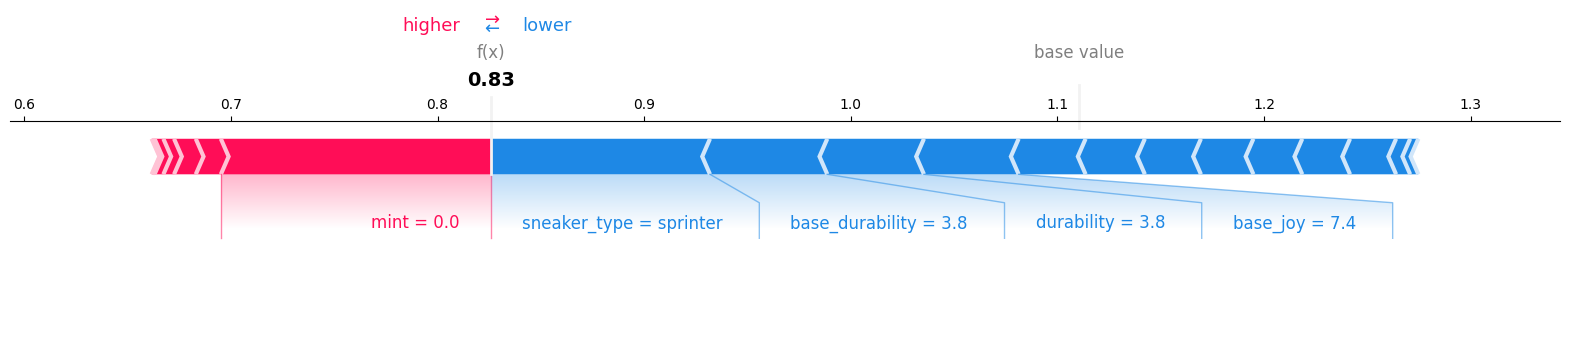

In [68]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

# Base Model

In [69]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    ]
cat_features = [0, 1, 2]

In [70]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [71]:
X.genesis.value_counts()

False    5008
True     1821
Name: genesis, dtype: int64

In [72]:
X

,rarity,sneaker_type,genesis,level,base_performance,base_fortune,base_joy,base_durability,performance,fortune,joy,durability,mint
0,common,ranger,False,5.0,8.0,7.4,5.0,2.5,27.0,10.9,7.5,4.0,0.0
1,common,ranger,False,5.0,7.8,9.9,6.2,2.5,26.8,14.9,9.2,4.0,0.0
2,common,ranger,False,5.0,8.0,4.0,2.9,4.9,27.0,6.0,4.4,7.4,2.0
3,common,ranger,False,5.0,8.3,7.6,1.0,9.6,18.3,20.6,1.5,14.6,2.0
4,common,hiker,True,10.0,6.3,8.6,9.0,5.1,34.3,17.3,18.0,18.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6824,common,ranger,False,5.0,9.0,5.7,3.4,6.0,28.5,8.7,4.9,9.0,2.0
6825,common,ranger,False,5.0,3.3,9.1,3.1,2.5,19.8,13.6,4.6,4.0,2.0
6826,common,ranger,False,5.0,5.6,9.9,6.7,6.7,22.6,14.9,10.2,11.2,2.0
6827,common,ranger,False,5.0,6.4,4.9,1.4,5.6,21.4,7.4,1.9,11.6,2.0


In [73]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     iterations=1000,
    #     learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:01,  1.70s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:03,  1.72s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:05,  1.73s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:06,  1.72s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:08,  1.72s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:10,  1.72s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:12,  1.72s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:13,  1.71s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:15,  1.70s/it]iteritems is deprec

In [74]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.902,0.0783
MAE,0.105,0.0177
MSE,0.143,0.1615
RMSE,0.341,0.1671
MAPE,0.071,0.0030


In [75]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.902,0.0783
MAE,0.105,0.0177
MSE,0.143,0.1615
RMSE,0.341,0.1671
MAPE,0.071,0.0030


In [76]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.888, 'MAE': 0.105, 'MSE': 0.143, 'RMSE': 0.378, 'MAPE': 0.071}

In [77]:
# # Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


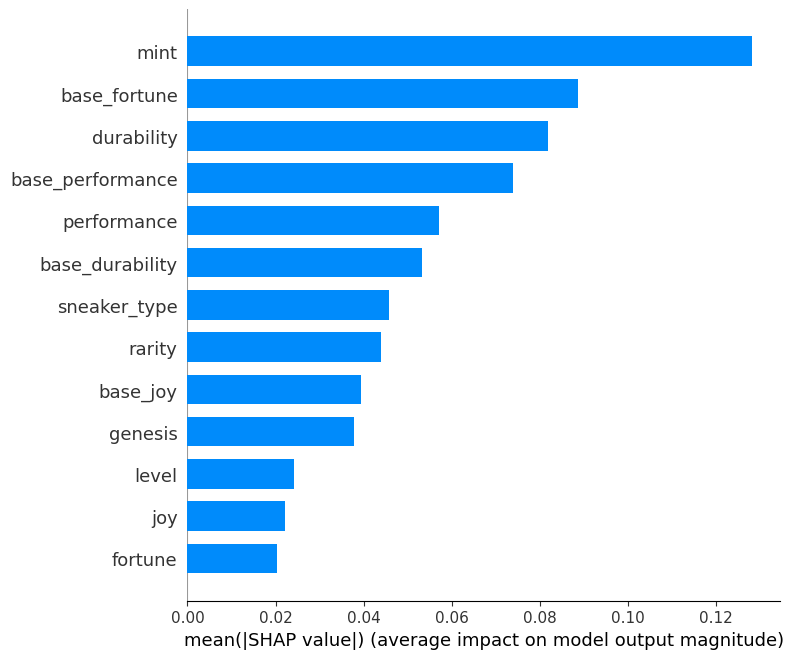

In [78]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

In [79]:
#shap.summary_plot(shap_values, train_x,)

## TEST

In [80]:
model = CatBoostRegressor(random_seed=42,)
model.fit(X_train, y_train, cat_features=cat_features,)

pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

Learning rate set to 0.053478
0:	learn: 1.0828434	total: 2.8ms	remaining: 2.79s
1:	learn: 1.0433078	total: 5.5ms	remaining: 2.75s
2:	learn: 1.0009497	total: 7.81ms	remaining: 2.6s
3:	learn: 0.9612300	total: 9.78ms	remaining: 2.44s
4:	learn: 0.9250337	total: 11.5ms	remaining: 2.29s
5:	learn: 0.8893684	total: 13.3ms	remaining: 2.21s
6:	learn: 0.8567680	total: 15.2ms	remaining: 2.15s
7:	learn: 0.8249556	total: 17ms	remaining: 2.1s
8:	learn: 0.7956736	total: 18.6ms	remaining: 2.05s
9:	learn: 0.7688665	total: 20.4ms	remaining: 2.02s
10:	learn: 0.7427221	total: 22.3ms	remaining: 2s
11:	learn: 0.7176363	total: 24ms	remaining: 1.97s
12:	learn: 0.6944403	total: 25.6ms	remaining: 1.94s
13:	learn: 0.6720164	total: 27.4ms	remaining: 1.93s
14:	learn: 0.6509028	total: 29.1ms	remaining: 1.91s
15:	learn: 0.6316758	total: 30.8ms	remaining: 1.89s
16:	learn: 0.6116367	total: 32.5ms	remaining: 1.88s
17:	learn: 0.5937064	total: 34.3ms	remaining: 1.87s
18:	learn: 0.5777669	total: 36.2ms	remaining: 1.87s
19:

{'R2': 0.831, 'MAE': 0.136, 'MSE': 0.122, 'RMSE': 0.35, 'MAPE': 0.121}

## Fit full Base model

In [81]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         iterations=1000,
#         learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_base_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.055464
0:	learn: 1.0339348	total: 2.05ms	remaining: 2.05s
1:	learn: 0.9921544	total: 4.78ms	remaining: 2.38s
2:	learn: 0.9518817	total: 7.37ms	remaining: 2.45s
3:	learn: 0.9142383	total: 9.7ms	remaining: 2.42s
4:	learn: 0.8787750	total: 11.9ms	remaining: 2.36s
5:	learn: 0.8438575	total: 13.7ms	remaining: 2.27s
6:	learn: 0.8115991	total: 15.5ms	remaining: 2.2s
7:	learn: 0.7813507	total: 17.4ms	remaining: 2.16s
8:	learn: 0.7529513	total: 19.4ms	remaining: 2.13s
9:	learn: 0.7269638	total: 21.4ms	remaining: 2.11s
10:	learn: 0.7025381	total: 23.3ms	remaining: 2.1s
11:	learn: 0.6791605	total: 25.2ms	remaining: 2.08s
12:	learn: 0.6544693	total: 27.2ms	remaining: 2.06s
13:	learn: 0.6329681	total: 29.2ms	remaining: 2.06s
14:	learn: 0.6139312	total: 31.3ms	remaining: 2.05s
15:	learn: 0.5942862	total: 33.2ms	remaining: 2.04s
16:	learn: 0.5763897	total: 35.1ms	remaining: 2.03s
17:	learn: 0.5584034	total: 37ms	remaining: 2.02s
18:	learn: 0.5415391	total: 38.9ms	remaining: 2.0

### Test

In [82]:
sneaker_dict = {
    'rarity': 'common',
    'sneaker_type': 'coacher',
    'genesis': True,
    #'genesis': False,
    'level': 19,
    'base_performance': 5.4,
    'base_fortune': 8.1,
    'base_joy': 9.6,
    'base_durability': 8.0,
    'performance': 71.9,
    'fortune': 23.3,
    'joy': 28.1,
    'durability': 23.2,
    #'condition': 100,
    'mint': 2,
}

In [83]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(pd.Series(sneaker_dict)[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.132

iteritems is deprecated and will be removed in a future version. Use .items instead.


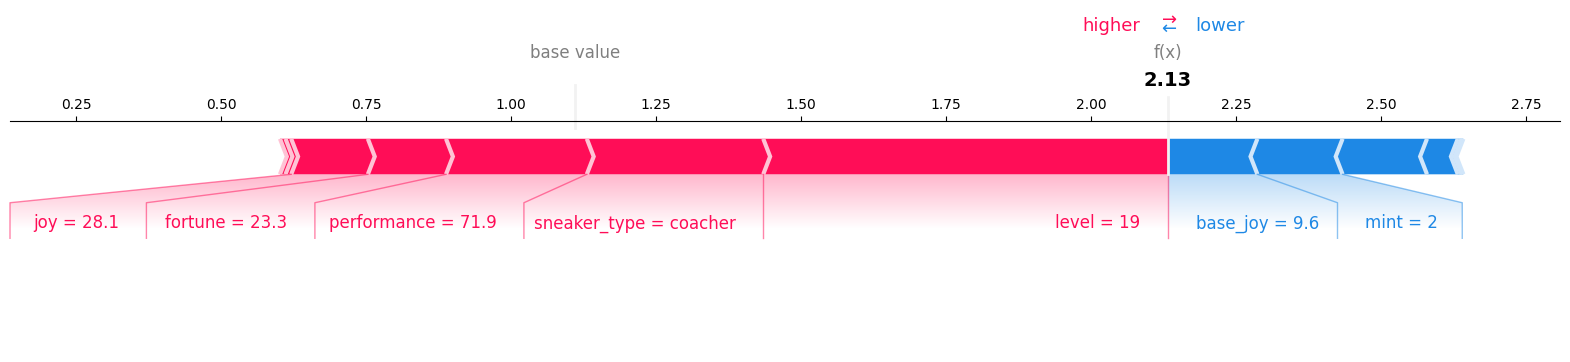

In [84]:
sample = pd.DataFrame(pd.Series(sneaker_dict)[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

iteritems is deprecated and will be removed in a future version. Use .items instead.


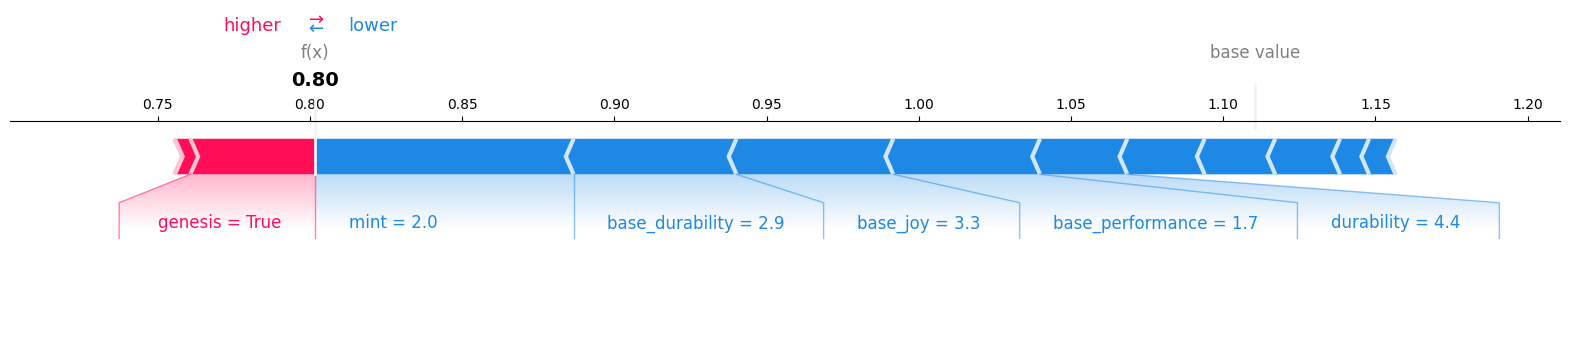

In [85]:
sample = data[data['token_id'] == 20928][model.feature_names_][:1]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)
#plt.savefig(f'explainer_{VERSION}.png', dpi=700)
#plt.show()

In [86]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=False, matplotlib=True).savefig(f'sneaker_base_model_explainer_img.png', format = "png", dpi = 150, bbox_inches = 'tight')

# Box Model

## Data

In [87]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')

Columns (67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.


In [88]:
#data.genesis = data.genesis.fillna(0).astype(int).astype(bool)

In [89]:
data = data[(data.item_type == 'box') & (data.event == 'buy')].copy().reset_index(drop=True)
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1664126430,39990,59242,buy,0xc086823eeb70ac2084f1cb8aec1307ceac247aca,0x25e67519a31b61c2e488f5a412da06cdd0a17054,0.89,box,common,NaN,...,597.0,8529.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,100.0,1.380952
1,1664123355,39985,59114,buy,0xd24bd3d09f1202f65531530407b46ffa89c31469,0xc937de0f393752b7c1108947ac45b34bed5b1956,0.90,box,common,NaN,...,601.0,8527.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,100.0,1.380952
2,1664119759,40010,59220,buy,0xebca9d57555ad95725cd8fb0384b16a67a134e89,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.88,box,common,NaN,...,612.0,8531.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,101.0,1.404762
3,1664103028,39386,58875,buy,0x72f49b95bf4da69c6fd2cb5bda518251dbc75ffe,0x3df43b2ba58581a54e28df689e36016dbd36b324,3.20,box,uncommon,NaN,...,569.0,8522.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,97.0,1.309524
4,1664102839,39626,59075,buy,0xfb3b54458534a7d50439fd8062885f49523ec20d,0x3df43b2ba58581a54e28df689e36016dbd36b324,3.10,box,uncommon,NaN,...,569.0,8522.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,98.0,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,1661070301,13989,33249,buy,0x3869363159f953feed0959fc23e32f60d784b249,0xf2e2a51537fac7b62234c57e1ef35c6dc35536d1,0.89,box,common,NaN,...,NaN,NaN,905,0,397,1702,2056,2549,NaN,NaN
978,1661054035,13521,227,buy,0xfbe5e186feacd47fedfbc91e4c9b0c64db928784,0xd5da766c451b21ab962e99a34675102dd96eaab6,1.50,box,common,NaN,...,NaN,NaN,904,0,388,1664,2002,2492,NaN,NaN
979,1661034370,13747,32215,buy,0x07a42ed43e24b0d23fe6b347378ccdac7c448397,0x5e56fc61fc07cba1367e8bccb0ef919116c71d74,0.98,box,common,NaN,...,NaN,NaN,903,0,253,1505,1844,2328,NaN,NaN
980,1661033512,13544,32564,buy,0x560e7af378e08e0681e0df3cda652078a6c3cdb9,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0.95,box,common,NaN,...,NaN,NaN,904,0,249,1502,1840,2324,NaN,NaN


In [90]:
data = data[((~data['parent1_sneaker_type'].isna() & (~data['parent2_sneaker_type'].isna())) | (data['genesis']))].copy().reset_index(drop=True)

In [91]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [92]:
len(data)

982

In [93]:
len(data[data.date >= START_DATE])

616

In [94]:
data = data[data.date >= START_DATE].reset_index(drop=True).copy()

In [95]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
0,1.659602e+09,6978.0,6.0,6.0,NaN,1800.0,300.0,200.0,0.676773
1,1.657800e+09,11145.0,8.0,6.0,NaN,1800.0,300.0,200.0,0.676012
2,1.657800e+09,23229.0,6.0,4.0,NaN,1800.0,300.0,200.0,0.677113
3,1.657802e+09,21564.0,6.0,5.0,NaN,1800.0,300.0,200.0,0.639683
4,1.657801e+09,38277.0,8.0,3.0,NaN,1800.0,300.0,200.0,0.642806
...,...,...,...,...,...,...,...,...,...
611,1.661001e+09,537.0,12.0,18.0,NaN,1800.0,1200.0,800.0,2.376476
612,1.662148e+09,12226.0,1.0,0.0,NaN,1800.0,1200.0,800.0,2.378457
613,1.657800e+09,3422.0,12.0,4.0,NaN,1800.0,300.0,200.0,0.592878
614,1.662806e+09,7804.0,3.0,0.0,NaN,1800.0,300.0,200.0,0.601538


In [96]:
data[['timestamp', 'mrk_id', 'token_id', 'event', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type', 'date']]

,timestamp,mrk_id,token_id,event,genesis,parent1_sneaker_type,parent2_sneaker_type,date
0,1662164401,21798,40436,buy,False,hiker,hiker,2022-09-03 00:20:01
1,1662170890,21796,40464,buy,False,hiker,sprinter,2022-09-03 02:08:10
2,1662171007,21614,38512,buy,False,coacher,coacher,2022-09-03 02:10:07
3,1662181762,21801,40467,buy,False,ranger,ranger,2022-09-03 05:09:22
4,1662186301,21623,38529,buy,False,coacher,coacher,2022-09-03 06:25:01
...,...,...,...,...,...,...,...,...
611,1664102839,39626,59075,buy,False,sprinter,sprinter,2022-09-25 10:47:19
612,1664103028,39386,58875,buy,False,hiker,hiker,2022-09-25 10:50:28
613,1664119759,40010,59220,buy,False,sprinter,sprinter,2022-09-25 15:29:19
614,1664123355,39985,59114,buy,False,hiker,hiker,2022-09-25 16:29:15


In [97]:
data.genesis.value_counts()

False    575
True      41
Name: genesis, dtype: int64

In [98]:
sneaker_types = ['ranger', 'sprinter', 'hiker', 'coacher']

In [99]:
from itertools import combinations
sneaker_combs = list(combinations(sneaker_types, 2))

In [100]:
comb_features = []

for sneaker_comb in sneaker_combs:
    #print(sneaker_comb[0])
    feature_name = f'{sneaker_comb[0]}_{sneaker_comb[1]}'
    data[feature_name] = (((data['parent1_sneaker_type'] == sneaker_comb[0]) & (data['parent2_sneaker_type'] == sneaker_comb[1])) | ((data['parent1_sneaker_type'] == sneaker_comb[1]) & (data['parent2_sneaker_type'] == sneaker_comb[0])))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)
    #break

for sneaker_type in sneaker_types:
    feature_name = f'{sneaker_type}_{sneaker_type}'
    data[feature_name] = ((data['parent1_sneaker_type'] == sneaker_type) & (data['parent2_sneaker_type'] == sneaker_type))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)

In [101]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,ranger_sprinter,ranger_hiker,ranger_coacher,sprinter_hiker,sprinter_coacher,hiker_coacher,ranger_ranger,sprinter_sprinter,hiker_hiker,coacher_coacher
0,1662164401,21798,40436,buy,0xc57ca482a3e1d0eef363166295962163b2f64ed0,0x710b6677ea43dc7cbf513248b896a6f28171b709,1.13,box,common,NaN,...,0,0,0,0,0,0,0,0,1,0
1,1662170890,21796,40464,buy,0xf7b7c0f111fe7bf762fc2c706aee194a39758e95,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.13,box,common,NaN,...,0,0,0,1,0,0,0,0,0,0
2,1662171007,21614,38512,buy,0x2a3f0c8349bde254599ed019a2d1994de06b7803,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.18,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
3,1662181762,21801,40467,buy,0x80dd92e3473e45c935edce170191810dc93bc56b,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.09,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0
4,1662186301,21623,38529,buy,0x50975867d5c0bad1b78ebf4b06252be9bdb76c64,0x741d48c325f4d29e9961cc86239a96070b3a1f4e,1.20,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,1664102839,39626,59075,buy,0xfb3b54458534a7d50439fd8062885f49523ec20d,0x3df43b2ba58581a54e28df689e36016dbd36b324,3.10,box,uncommon,NaN,...,0,0,0,0,0,0,0,1,0,0
612,1664103028,39386,58875,buy,0x72f49b95bf4da69c6fd2cb5bda518251dbc75ffe,0x3df43b2ba58581a54e28df689e36016dbd36b324,3.20,box,uncommon,NaN,...,0,0,0,0,0,0,0,0,1,0
613,1664119759,40010,59220,buy,0xebca9d57555ad95725cd8fb0384b16a67a134e89,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.88,box,common,NaN,...,0,0,0,0,0,0,0,1,0,0
614,1664123355,39985,59114,buy,0xd24bd3d09f1202f65531530407b46ffa89c31469,0xc937de0f393752b7c1108947ac45b34bed5b1956,0.90,box,common,NaN,...,0,0,0,0,0,0,0,0,1,0


In [102]:
comb_features

['ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [103]:
data['ranger_hiker'].sum()

59

## FE

In [104]:
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']
data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']

# Model

In [105]:
features = [
    'rarity', 
    'genesis',
    'buy_count_12H',
    'buy_count_24H',
    'sum_activity_24H',
    'sells_activity_24H',
    'min_price_all_24H',
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'wallet_from_buy_count',
    #'wallet_from_all_count', 
    *comb_features
    ]
cat_columns = ['rarity',]
cat_features = [0,]

In [106]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [107]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  1.35it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:01,  1.35it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:02,  1.37it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:02,  1.36it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:03,  1.37it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:04,  1.37it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:05,  1.37it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:05,  1.37it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:06,  1.36it/s]iteritems is deprec

In [108]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.750,0.3245
MAE,0.099,0.0696
MSE,0.403,0.7412
RMSE,0.393,0.5069
MAPE,0.049,0.0090


In [109]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.750,0.3245
MAE,0.099,0.0696
MSE,0.403,0.7412
RMSE,0.393,0.5069
MAPE,0.049,0.0090


In [110]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.466, 'MAE': 0.099, 'MSE': 0.403, 'RMSE': 0.635, 'MAPE': 0.049}

iteritems is deprecated and will be removed in a future version. Use .items instead.


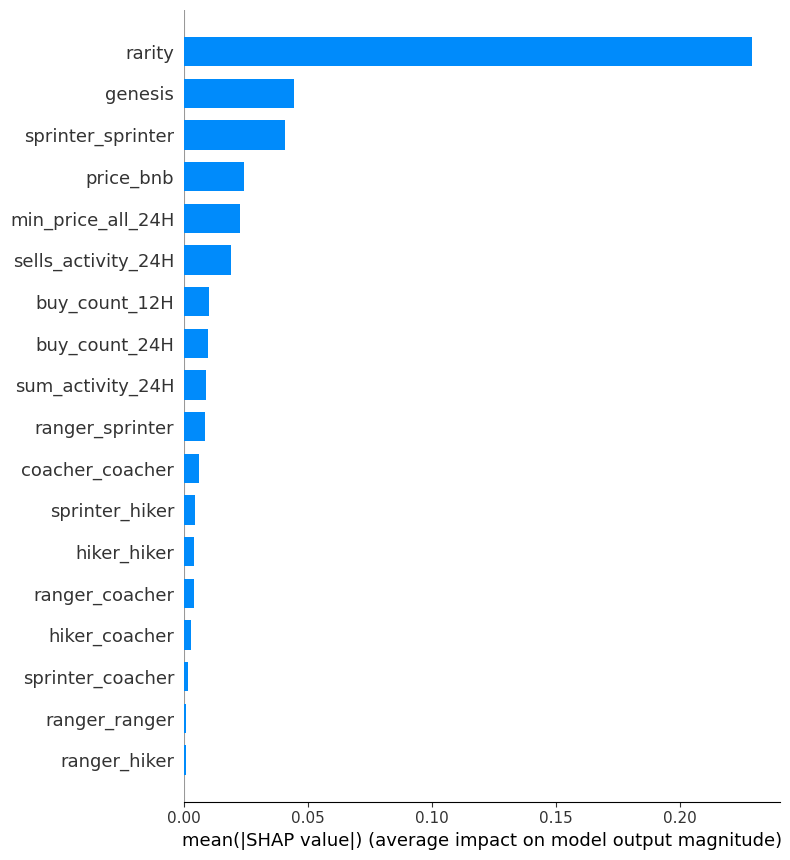

In [111]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar',)

## Fit Box Model on full data

In [112]:
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_model_{VERSION}.model')

Learning rate set to 0.037926
0:	learn: 0.8542819	total: 1.37ms	remaining: 1.37s
1:	learn: 0.8402460	total: 2.45ms	remaining: 1.22s
2:	learn: 0.8263550	total: 3.63ms	remaining: 1.21s
3:	learn: 0.8116439	total: 4.64ms	remaining: 1.16s
4:	learn: 0.7981757	total: 5.75ms	remaining: 1.14s
5:	learn: 0.7851380	total: 6.81ms	remaining: 1.13s
6:	learn: 0.7713060	total: 7.45ms	remaining: 1.06s
7:	learn: 0.7591719	total: 8.35ms	remaining: 1.03s
8:	learn: 0.7470603	total: 9.18ms	remaining: 1.01s
9:	learn: 0.7352126	total: 10ms	remaining: 991ms
10:	learn: 0.7244106	total: 10.9ms	remaining: 978ms
11:	learn: 0.7118709	total: 11.7ms	remaining: 963ms
12:	learn: 0.7003374	total: 12.5ms	remaining: 947ms
13:	learn: 0.6900766	total: 13.2ms	remaining: 928ms
14:	learn: 0.6783193	total: 13.8ms	remaining: 907ms
15:	learn: 0.6673095	total: 14.4ms	remaining: 889ms
16:	learn: 0.6567834	total: 15ms	remaining: 870ms
17:	learn: 0.6463501	total: 15.7ms	remaining: 856ms
18:	learn: 0.6370070	total: 16.3ms	remaining: 84

### Test

In [113]:
i = 250

In [114]:
box_dict = {}

features = data.columns

for feature in features:
    box_dict[feature] = data.iloc[i][feature]

box_dict['sum_activity_24H'] = box_dict['buy_count_24H'] + box_dict['sell_count_24H'] + box_dict['cancel_count_24H']
box_dict['sells_activity_24H'] = box_dict['sell_count_24H'] / box_dict['buy_count_24H']

box_dict

{'timestamp': 1662994885,
 'mrk_id': 27361,
 'token_id': 47029,
 'event': 'buy',
 'wallet_from': '0x0885157dbb0db47f63477b1d88c62a8b5193aefa',
 'wallet_to': '0xf06301c9b159e20d019995b4943f075b6b28e246',
 'price': 1.0,
 'item_type': 'box',
 'rarity': 'common',
 'sneaker_type': nan,
 'level': 0.0,
 'base_performance': nan,
 'base_fortune': nan,
 'base_joy': nan,
 'base_durability': nan,
 'performance': nan,
 'fortune': nan,
 'joy': nan,
 'durability': nan,
 'mint': nan,
 'parent1': 19505.0,
 'parent2': 19511.0,
 'genesis': False,
 'parent1_sneaker_type': 'ranger',
 'parent2_sneaker_type': 'sprinter',
 'price_bnb': 297.38936778,
 'price_azy': 0.09238833,
 'price_amt': 0.55592094,
 'wallet_from_buy_count': 2,
 'wallet_from_all_count': 9,
 'token_all_activity_3H': 0,
 'token_sell_activity_6H': 0,
 'buy_count_12H': 16,
 'buy_count_24H': 25,
 'buy_count_48H': 55,
 'sell_count_12H': 18,
 'sell_count_24H': 40,
 'sell_count_48H': 96,
 'cancel_count_12H': 9,
 'cancel_count_24H': 24,
 'cancel_coun

In [115]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')

template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']
template_data['buy_count_12H'] = box_dict['buy_count_12H']
template_data['buy_count_24H'] = box_dict['buy_count_24H']
template_data['sells_activity_24H'] = box_dict['sells_activity_24H']
template_data['sum_activity_24H'] = box_dict['sum_activity_24H']
template_data['min_price_all_24H'] = box_dict['min_price_all_24H']
template_data['wallet_from_buy_count'] = box_dict['wallet_from_buy_count']
template_data['wallet_from_all_count'] = box_dict['wallet_from_all_count']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity                   common
genesis                   False
buy_count_12H                16
buy_count_24H                25
sum_activity_24H             89
sells_activity_24H          1.6
min_price_all_24H           0.9
price_bnb                   NaN
ranger_sprinter               1
ranger_hiker                NaN
ranger_coacher              NaN
sprinter_hiker              NaN
sprinter_coacher            NaN
hiker_coacher               NaN
ranger_ranger               NaN
sprinter_sprinter           NaN
hiker_hiker                 NaN
coacher_coacher             NaN
wallet_from_buy_count         2
wallet_from_all_count         9
dtype: object

In [116]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.03

In [117]:
data.iloc[i]['price']

1.0

In [118]:
template_data['genesis'] = True

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.429

In [119]:
template_data['rarity'] = 'uncommon'

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

2.724

# Box Base Model

In [120]:
features = ['rarity', 'genesis', *comb_features]
cat_columns = ['rarity',]
cat_features = [0,]

In [121]:
features

['rarity',
 'genesis',
 'ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [122]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [123]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rarity             616 non-null    object
 1   genesis            616 non-null    bool  
 2   ranger_sprinter    616 non-null    int64 
 3   ranger_hiker       616 non-null    int64 
 4   ranger_coacher     616 non-null    int64 
 5   sprinter_hiker     616 non-null    int64 
 6   sprinter_coacher   616 non-null    int64 
 7   hiker_coacher      616 non-null    int64 
 8   ranger_ranger      616 non-null    int64 
 9   sprinter_sprinter  616 non-null    int64 
 10  hiker_hiker        616 non-null    int64 
 11  coacher_coacher    616 non-null    int64 
dtypes: bool(1), int64(10), object(1)
memory usage: 53.7+ KB


In [124]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # train_data = Pool(
    #     train_x, 
    #     train_y,
    #     cat_features=cat_features,
    #     )

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  2.07it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  2.11it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  2.09it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:01,  2.07it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:02,  2.07it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:02,  2.06it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:03,  2.07it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:03,  2.09it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:04,  2.06it/s]iteritems is deprec

In [125]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.760,0.3324
MAE,0.113,0.0704
MSE,0.394,0.7230
RMSE,0.393,0.4980
MAPE,0.061,0.0100


In [126]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.760,0.3324
MAE,0.113,0.0704
MSE,0.394,0.7230
RMSE,0.393,0.4980
MAPE,0.061,0.0100


In [127]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.477, 'MAE': 0.113, 'MSE': 0.395, 'RMSE': 0.628, 'MAPE': 0.061}

iteritems is deprecated and will be removed in a future version. Use .items instead.


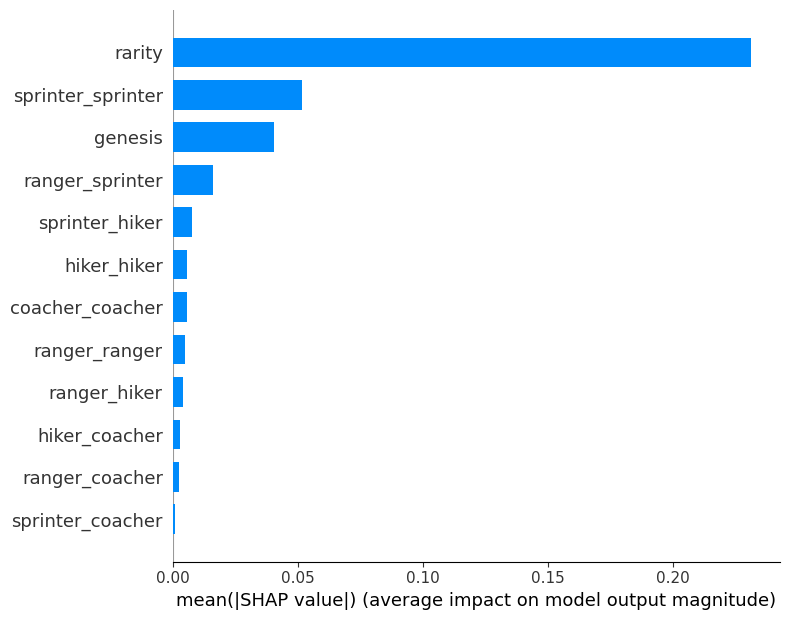

In [128]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## Fit on full data

In [129]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         #iterations=1000,
#         #learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_base_model_{VERSION}.model')

Learning rate set to 0.037926
0:	learn: 0.8532975	total: 1.32ms	remaining: 1.32s
1:	learn: 0.8376382	total: 1.99ms	remaining: 992ms
2:	learn: 0.8233180	total: 2.65ms	remaining: 883ms
3:	learn: 0.8087181	total: 3.15ms	remaining: 785ms
4:	learn: 0.7970916	total: 3.67ms	remaining: 730ms
5:	learn: 0.7857332	total: 4.44ms	remaining: 735ms
6:	learn: 0.7752863	total: 5.45ms	remaining: 772ms
7:	learn: 0.7618228	total: 6.26ms	remaining: 776ms
8:	learn: 0.7492072	total: 6.71ms	remaining: 739ms
9:	learn: 0.7373305	total: 7.41ms	remaining: 734ms
10:	learn: 0.7248466	total: 8.18ms	remaining: 735ms
11:	learn: 0.7133847	total: 8.55ms	remaining: 704ms
12:	learn: 0.7026453	total: 9.12ms	remaining: 692ms
13:	learn: 0.6941480	total: 9.47ms	remaining: 667ms
14:	learn: 0.6834974	total: 10ms	remaining: 658ms
15:	learn: 0.6736401	total: 10.3ms	remaining: 636ms
16:	learn: 0.6657789	total: 10.7ms	remaining: 619ms
17:	learn: 0.6586670	total: 10.9ms	remaining: 597ms
18:	learn: 0.6486213	total: 11.3ms	remaining: 

## Test

In [130]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.811

In [131]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'sprinter',
}

In [132]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')
template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker          NaN
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [133]:
if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker            1
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [134]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.056

In [135]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'coacher',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.174

In [136]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'coacher',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.174

In [137]:
box_dict = {
    'rarity': 'common',
    'genesis': True,
    'parent1_sneaker_type': '',
    'parent2_sneaker_type': '',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.46

In [138]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.118

In [139]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'ranger',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.084

фитчи из блока:
- маркер перекупа
- количество кроссов у продающего
- базовые хорактеристики
- разницу между базовыми
- сорость прошлой покупки
- количество перепродаж
- количество перевыставлений
- сколько времени весит на маркете кросс
- время выставления
- время после последнего апдейта цены
- количество обновлений цены (одним владельцем)
- окупаемость 
- количество транзакций на кросовке
- количество минта на акке продавца
- когда начал работать продовец с ази
- прошлая цена продажи (и их разница)
- время владения кроссом одним продавцом


Данные по рынку:
- количество транзакций на токене
- количество ордеров (бай, селл, кансел)
- количество ордеров за периоды (бай, селл, кансел)
- разница среднего количества ордеров за период и текущего за день.
- количество холдеров
- количество кроссовок вообще
- количество новых кросовок за периоды (день, 3 дня, неделя и тд)
- количество кроссовок сейчас на рынке
- разница от всего кроссов и сейчас на рынке
- цена токена атм
- цена токена azy
- цена бнб и битка
- изменение цены бнб и битка
- изменение соотношения генезис кроссов к обычным
- изменение соотношения по классам
- цены на боксы
- количество боксов на рынке
- количество кроссов/боксы
- стоимость минта
- прибыльность минта 
- день недели # 7 мин
- выходные # 7 мин
- средние цены кроссов 0 уровня по типам за периоды # 30 мин

внешние данные:
- количество подпищеков в телеге твите



In [140]:
# import ast
# import json

In [141]:
# json_data = "{'token_id': 22259, 'rarity': 'common', 'sneaker_type': 'hiker', 'genesis': False, 'level': 5, 'base_performance': 3.0, 'base_fortune': 2.7, 'base_joy': 7.3, 'base_durability': 3.5, 'performance': 16.5, 'fortune': 4.2, 'joy': 10.8, 'durability': 8.5, 'mint': 2, 'wallet_from_buy_count': 0, 'wallet_from_all_count': 1, 'buy_count_12H': 97, 'buy_count_24H': 191, 'sell_count_24H': 430, 'cancel_count_24H': 238, 'min_price_all_24H': 0.6, 'min_price_by_rarity_genesis_type_level_mint_24H': 0.7, 'min_price_by_rarity_genesis_type_24H': 0.7, 'token_all_activity_3H': 1, 'token_sell_activity_6H': 1, 'explain_models': True}"
# json_data = ast.literal_eval(json_data)

In [142]:
# print(json.dumps(json_data))

In [143]:
# import requests

# r = requests.post(
#     "http://65.21.94.236:8003/sneaker_predict_price", 
#     data=json.dumps(json_data))
# print(r.status_code, r.reason)

In [144]:
#output = json.loads(r.text)

In [145]:
# from PIL import Image
# import base64
# import io 

# im = Image.open(io.BytesIO(base64.b64decode(output['sneaker_model_predict_explain_img'])))
# im.show()

групировку делать по sell оредерам